#Overview
Problem: Generate flow systems through multi-objective ant colony optimzation.

Why use ABM/Networks: The system generation process can be modeled as set of consecutive decisions (next path->path capacity->repeat) with the path options defined by a network. Ant colony optimization methods have been shown to provide high quality solutions to these types of decision making problems by incrementally increasing the attractiveness of a decision when it is associated with a good solution.

Outline model - identify process, parameters and what will be measured
Process: Given a network that defines the available system space, the model will produce a set of ants that follow pheromone trails to create a system. The space's possible paths are populated with an initial pheromone amount which decays with time and is incrementally increased when a successful ant uses that path. Ants progress through the space by a random walk influenced by the pheromone of each path option. Each step of the random walk also has an associated capacity decision which is also decided based on pheromones. After an ant finishes a random walk, the path is scored and compared with the quality of the other generated paths. The highest quality ants then update the pheromones of their path with an incremental increase. This process repeats until the ants converge to a single path or an iteration limit is met.

Parameters:
size - currently used to create a grid space
num_ants - number of ants that generate paths
source - list of source locations and their magnitude
sink - list of sink locations and their magnitude
dissipation - how much pheromones dissipate each model step
pheromon_drop - how much successful ants increase the pheromones
capacities - the list of possible capacities for each edge

Measures:
ant_graph - the graph that an ant creates through random walk
score - the score given to an ant's graph (current: flow and length, final: survivability and complexity)

To Do:
Splitting Ants based on pheromone at each node.
Create two ant colonies - one for each objective - to create more solution diversity.
    Ants will gather an aggregate pheromone as a combination of pheromones from each colony.
Formal objective functions.
    Complexity - combination of fuctional complexity and graph energy
    Survivability - score of flow after graph destruction



# Primary Methods
##Space:
setup_space() - creates the directed grid network and initializes pheromones and capacity 
setup_ants() - initialized each ant agent
step() - model step function which calls each ant to create graph, gathers the best ants as decided by ant_ranking() and then updates the pheromones for the best ants.
evaluate_graph() - gets the score of each objective function for a graph created by an ant
ant_ranking() - ranks ants depending on if their score was on the pareto front of all scores
pheromone update - while not currently a separate method, occurs at the end of each step to update the pheromone trails of the highest ranked ants.


##Ant:
random_walk() - generates a graph of an ant's path through the space by consecutively to new nodes that are randomly chosen based on pheromone strenghts. Each step of the walk also adds a capacity to the edge created.

make_decision() - takes in a pheromone list for a decision (next node, capacity) and returns the decision that the ant makes.


In [1]:
'''
IMPORTS
'''

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = ant_id
        
    def random_walk(self,source,sink):
        #Random Walk
        #initialize method
        self.source=source
        self.sink=sink
        self.g=nx.DiGraph()
        
        #initialize start of random walk
        self.last_nodes=self.source

        #Create path for an ant
        terminate=0
        while not terminate:
            terminate=1
            for i in xrange(len(self.last_nodes)):
                '''
                Ant step is encompassed below
                '''
                #track next nodes
                self.last_nodes_next=[]
                #get neighbors
                self.base_node=self.last_nodes[i]
                #self.base_node=self.last_nodes.pop()
                self.p_neighbors=self.get_neighbors(self.base_node)
                
                #get pheromone of each edge to neighbor
                self.edge_pheromone_list=[]
                for self.potential_node in self.p_neighbors:
                    self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node)))
                
                #get next node
                self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                self.last_nodes_next.append(self.next_node)
                
                #add edge
                self.g.add_edge(self.base_node,self.next_node)
                #print(self.g.nodes())
                
                #get capacity pheromones
                self.capacity_pheromone_list=self.get_pheromone_capacity((self.base_node,self.next_node))
                
                #decide capacity
                self.capacity_to_add=self.model.capacities[self.make_decision(self.capacity_pheromone_list)]
                
                #add capacity
                self.g[self.base_node][self.next_node]['capacity']=self.capacity_to_add
                
                #Check termination criteria - are all sinks in the graph
                for sink_node in self.sink:
                    if sink_node not in self.g:
                        terminate=0
                        
            self.last_nodes=self.last_nodes_next   

        return (self.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    
    #def get_pheromone_node(self,node):
        """
        Return node pheromone, calling through model.
        """    
    
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge)

    def get_pheromone_capacity(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [23]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,source=[[(0,0)],[10]],sink=[[(2,2)],[5]],dissipation=.8,pheromone_drop=.5,capacities=[1,5,10]):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink[0]
        self.sink_magnitude = sink[1]
        self.source=source[0]
        self.source_magnitude = source[1]        
        self.num_ants=num_ants
        self.dissipation=dissipation
        self.pheromone_drop=pheromone_drop
        self.capacities=capacities
        
        # Set our state variables
        self.t = 0
        self.ants = []

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=self.size)
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print('Setting up network')
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0)
            self.g.add_edge(e[0],e[1],edge_pheromone=25)
            self.g.add_edge(e[0],e[1],capacity_pheromone=[25,25,25])

        self.g_layout = nx.spectral_layout(self.g)
 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """       
        # First, begin by creating all ants.
        for i in xrange(self.num_ants):
            self.ants.append(Ant(model=self,ant_id=i))
            
    def get_edge_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['edge_pheromone']
    
    def get_capacity_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['capacity_pheromone']
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        return self.ants[ant_id].random_walk(self.source,self.sink)
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
        #Score 1 - Length
        length_score=ant_graph.number_of_edges()
        
        #Score 2 - Flow
        #add aggregate sink
        flow_graph=ant_graph.copy()
        for i in xrange(len(self.sink)):
            flow_graph.add_edge(self.sink[i],'sink',capacity=self.sink_magnitude[i])
        
        #add aggregate source
        for i in xrange(len(self.source)):
            flow_graph.add_edge('source',self.source[i],capacity=self.source_magnitude[i])
        
        flow_value, flow_dict = nx.maximum_flow(flow_graph, 'source', 'sink')
        
        #flow is judged by the amount of flow that gets to the aggregate sink based on the total sink magnitude 
        flow_score=float(flow_value)/sum(self.sink_magnitude)       
        return (flow_score,length_score)
    
    def dominates(self, point_1, point_2, equality_sequence):
        '''
        Calculates if a point is dominated by another point, used in simple_cull_front
        equality_sequence:= 1 is '>=',0 is '<='
        '''
        score=0
        for i in range(len(point_1)):
            if equality_sequence[i]==1 and point_1[i]>=point_2[i]:
                score+=1
            elif equality_sequence[i]==0 and point_1[i]<=point_2[i]:
                score+=1
        dom=score==len(point_1)    
        return dom    
   
    def simple_cull_front(self, inputPoints, dominates, equality_sequence):
        '''
        Basic algorithm to find the pareto front of a set of points
        min or max is determined based on equality_sequence:= 0 is min, 1 is max
        '''
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if self.dominates(candidateRow, row,equality_sequence):
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif self.dominates(row, candidateRow, equality_sequence):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        [score_list.append(graph[1]) for graph in ant_graphs]
        #print(score_list)
        
        equality_sequence=[1,0] #[>=,<=]
        paretoPoints, dominatedPoints=self.simple_cull_front(score_list,self.dominates,equality_sequence)
        paretoPoints=list(paretoPoints)
        
        #get the best ants based on pareto front
        best_ants_index=[]
        
        #recreate the score list after it is deconstructed in simple_cull_front()
        [score_list.append(graph[1]) for graph in ant_graphs]
        
        #match the score_list indices to the pareto front values
        for i in xrange(len(score_list)):
            if score_list[i] in paretoPoints:
                best_ants_index.append(i)
                
        return best_ants_index, score_list
    
    
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_graphs=[]
        
        #Step for each ant
        for i in xrange(self.num_ants):
            self.ant_graph=self.get_path(i)
            
            #Evaluate Paths
            self.graph_score=self.evaluate_graph(self.ant_graph) 
            
            #List <graph,score>
            self.ant_graphs.append((self.ant_graph,self.graph_score))
            
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        
        #Update Institutions - Edges and capacities for this walk
        #Get pheromones
        self.edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        self.capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')
        
        #Reduce edge pheromones by input amount
        for key in self.edge_pheromone_dict:    
            self.edge_pheromone_dict[key]*=self.dissipation      
      
        #Increment through best paths to update
        for ant in self.opt_ant:
            for e in self.ant_graphs[ant][0].edges():
                #increase the pheromone amount of edges traveled by best ants
                self.edge_pheromone_dict[e]+=self.pheromone_drop
                
                #get capacity chosen and update pheromones
                self.capacity_chosen=self.ant_graphs[ant][0][e[0]][e[1]]['capacity']
                self.capacity_index=self.capacities.index(self.capacity_chosen)
                for i in xrange(len(self.capacity_pheromone_dict[e])):
                    self.capacity_pheromone_dict[e][i]*=self.dissipation
                    
                    #add pheromone if one chosen
                    if i == self.capacity_index:
                        self.capacity_pheromone_dict[e][i]+=self.pheromone_drop                                   
           
        
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', self.edge_pheromone_dict)
        
        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', self.capacity_pheromone_dict)
        

Setting up network
1
[(0.5, 10), (0.1, 6), (0.1, 10), (0.1, 5), (0.1, 5), (0.1, 6), (0.1, 31), (0.1, 16), (0.5, 4), (0.2, 15)]
2
[(0.6, 12), (0.1, 15), (0.1, 4), (0.1, 6), (0.5, 11), (0.1, 11), (0.1, 22), (0.6, 15), (0.5, 6), (0.1, 20)]
3
[(0.1, 15), (0.1, 10), (0.5, 8), (0.6, 19), (0.5, 7), (0.1, 16), (0.1, 8), (0.1, 17), (0.5, 11), (0.1, 18)]
4
[(0.5, 12), (0.6, 16), (0.1, 11), (0.1, 10), (1.0, 10), (0.1, 19), (0.1, 10), (0.1, 10), (0.1, 8), (0.1, 4)]
5
[(0.1, 10), (0.1, 14), (0.1, 10), (0.1, 20), (0.1, 16), (0.1, 9), (0.5, 9), (0.5, 7), (0.1, 25), (0.1, 6)]
6
[(0.5, 7), (0.1, 7), (0.1, 13), (0.1, 13), (0.6, 27), (0.1, 4), (0.2, 19), (0.5, 4), (0.1, 16), (0.1, 4)]
7
[(0.1, 11), (0.1, 10), (0.1, 6), (0.1, 10), (0.1, 14), (0.5, 4), (0.1, 16), (0.1, 25), (0.1, 26), (0.5, 7)]
8
[(0.1, 18), (0.5, 12), (0.1, 4), (0.1, 9), (0.1, 10), (0.2, 21), (0.1, 6), (0.5, 5), (0.5, 19), (0.1, 11)]
9
[(0.1, 6), (0.1, 5), (0.1, 7), (0.2, 20), (0.1, 9), (0.1, 10), (0.1, 15), (0.5, 5), (0.1, 11), (0.1, 14)

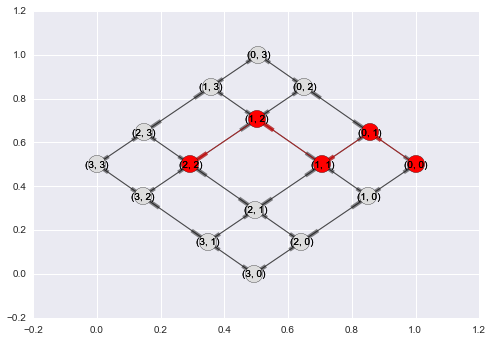

In [27]:
'''
Run Example
'''

space=Space(size=[4,4],num_ants=10,pheromone_drop=1,source=[[(0,0)],[10]],sink=[[(2,2)],[10]])
converged=0
i=1
while not converged:
    print(i)
    space.step()
    i+=1
    
    print space.score_list
    
    if i>100:
        converged=1
        

print('Ant Path')

    

# Remove the nonpath from path nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)
_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

# Overview of the results you hope to present: 
I hope to present an expanded ACO methodology that generates optimized system structures for a space with a set of sources and sinks. Specifically, I would like to show that the ACO formulation can lead to high quality system designs that meet complex objectives functions.

# Hypothesis about what results you will see: 
I think that the formulation will be able to generate high quality solutions but will suffer from number of decisions that must be made to generate a system. Because of this it will be a good demonstration of the model capabilities, but will be limited in the scope of what it could be applied to.